In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

## Dataset:

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/ SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [3]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [11]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop("hour", axis=1)

In [12]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


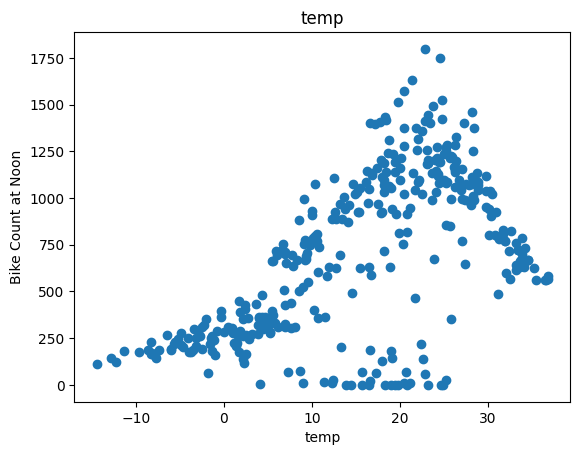

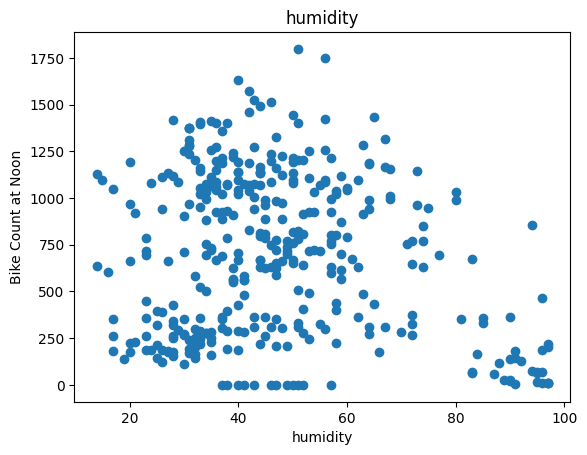

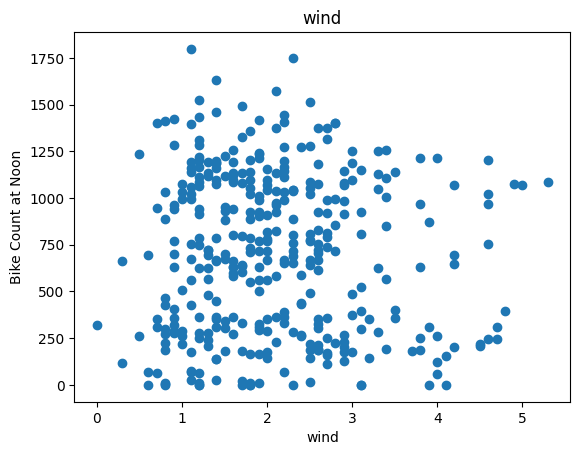

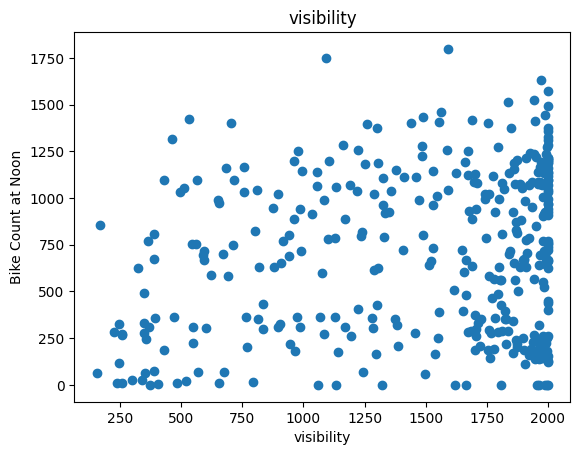

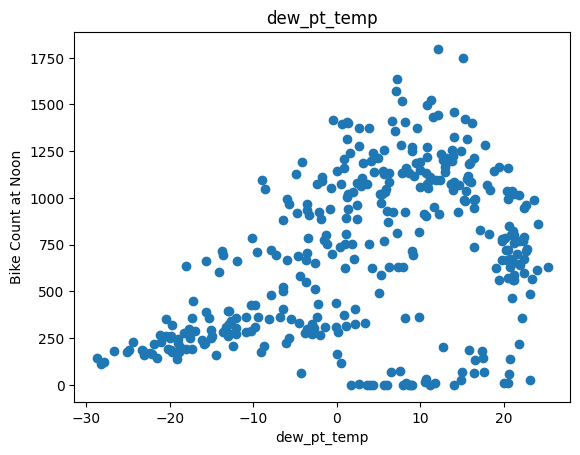

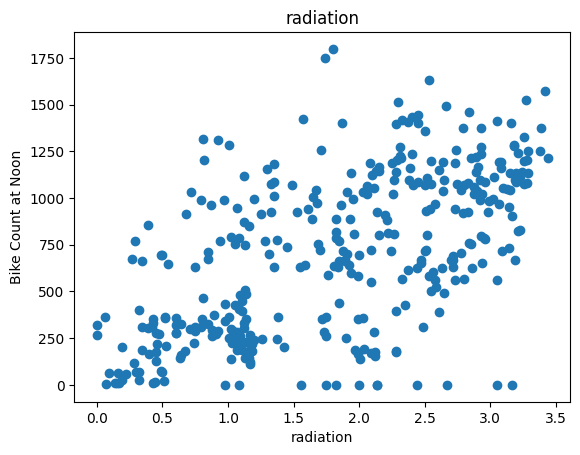

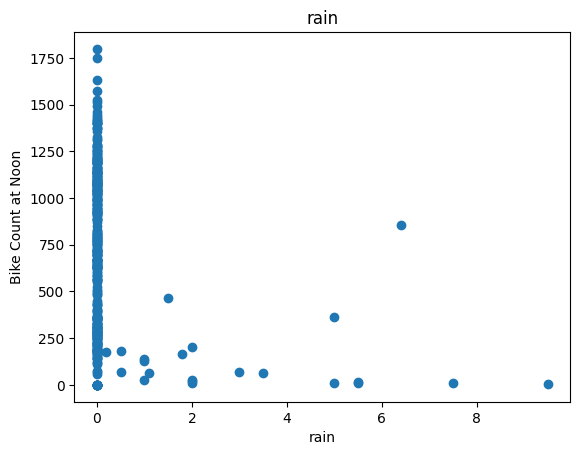

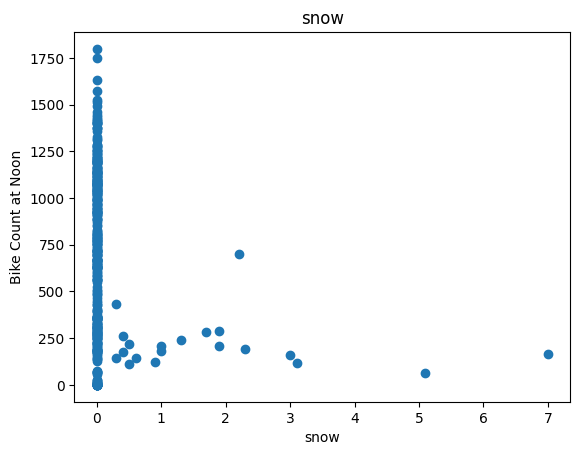

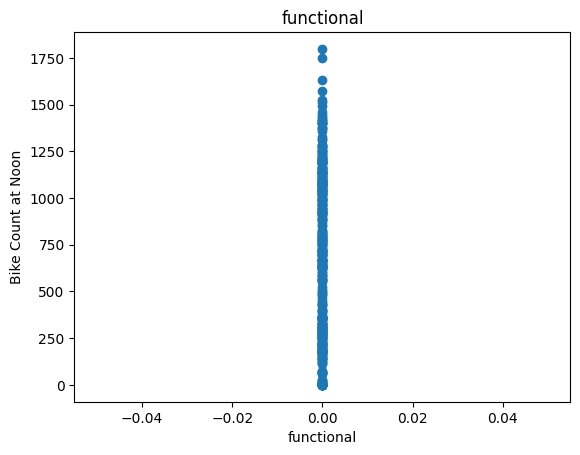

In [14]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [15]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [16]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Train / validate / test dataset

In [17]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [47]:
def getxy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    x = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((x, y))

  return data, x, y

In [48]:
_, x_train_temp, y_train_temp = getxy(train, "bike_count", x_labels=["temp"])
_, x_val_temp, y_val_temp = getxy(val, "bike_count", x_labels=["temp"])
_, x_test_temp, y_test_temp = getxy(test, "bike_count", x_labels=["temp"])

In [49]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [50]:
print(temp_reg.coef_, temp_reg.intercept_)

[[22.85751191]] [358.67686619]


In [51]:
temp_reg.score(x_test_temp, y_test_temp)

0.3343316050109676

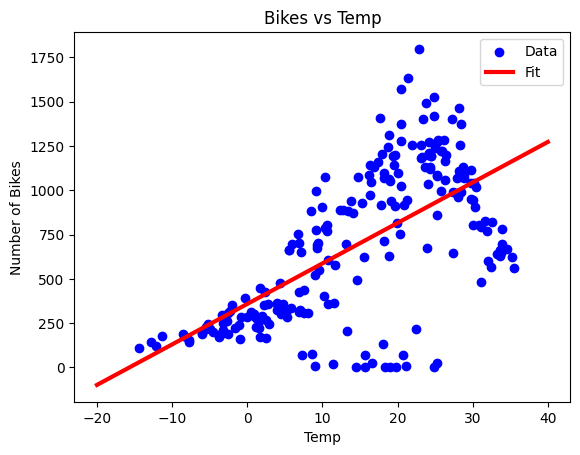

In [52]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

## Multiple Linear Regression

In [46]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, x_train_all, y_train_all = getxy(train, "bike_count", x_labels=df.columns[1:])
_, x_val_all, y_val_all = getxy(val, "bike_count", x_labels=df.columns[1:])
_, x_test_all, y_test_all = getxy(test, "bike_count", x_labels=df.columns[1:])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [54]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [55]:
all_reg.score(x_test_all, y_test_all)

0.463717784707221

In [104]:
y_pred_lr = all_reg.predict(x_test_all)

## Regression with Neural Net

In [65]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.legend()
  plt.grid(True)
  plt.show()

In [57]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units=1)
])

In [61]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=tf.keras.losses.MeanSquaredError())

In [62]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_temp, y_val_temp)
)

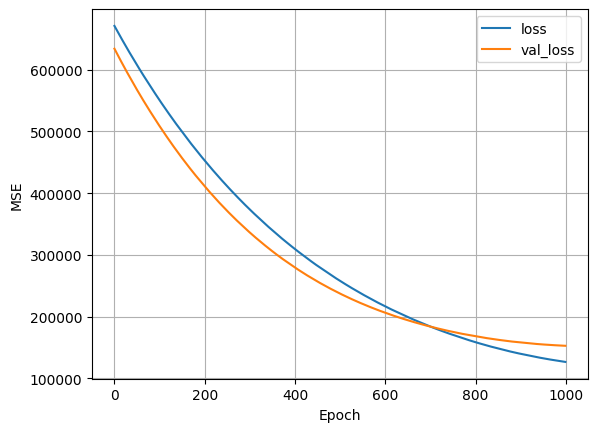

In [66]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


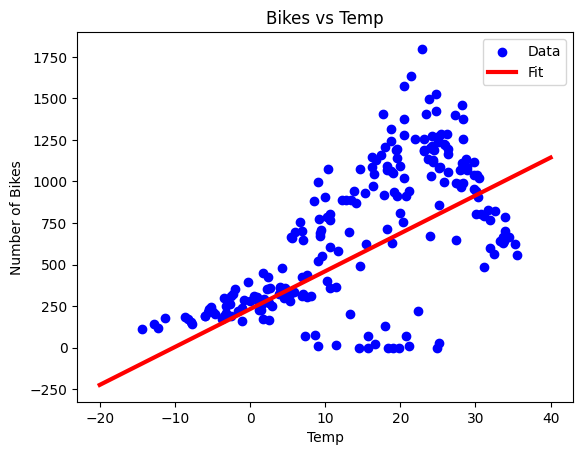

In [67]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

## Neural Net

In [80]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())

In [81]:
history = nn_model.fit(
    x_train_temp, y_train_temp,
    verbose=0,
    epochs=100,
    validation_data=(x_val_temp, y_val_temp)
)

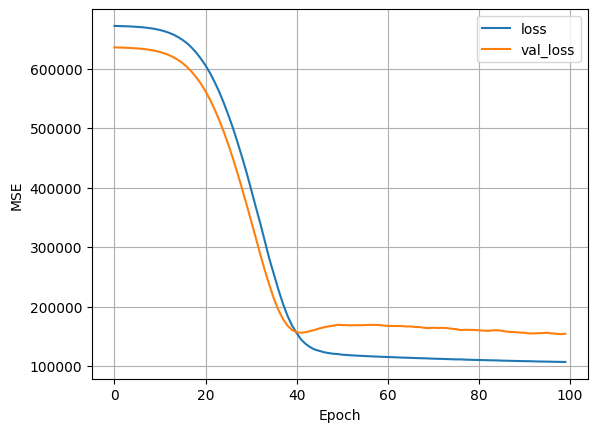

In [82]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


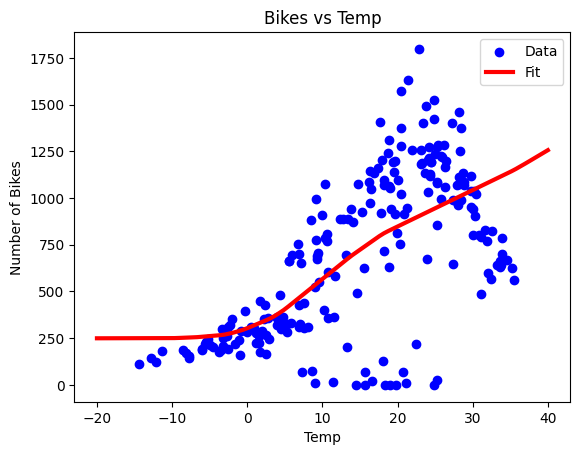

In [83]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

In [98]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)

In [99]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

In [100]:
history = nn_model.fit(
    x_train_all, y_train_all,
    verbose=0,
    epochs=100,
    validation_data=(x_val_all, y_val_all)
)

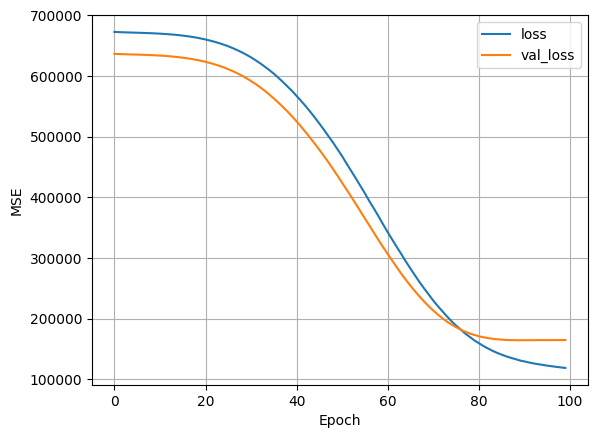

In [101]:
plot_loss(history)

In [105]:
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [107]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [108]:
MSE(y_pred_lr, y_test_all)

107736.255934004

In [109]:
MSE(y_pred_nn, y_test_all)

142969.8265758515

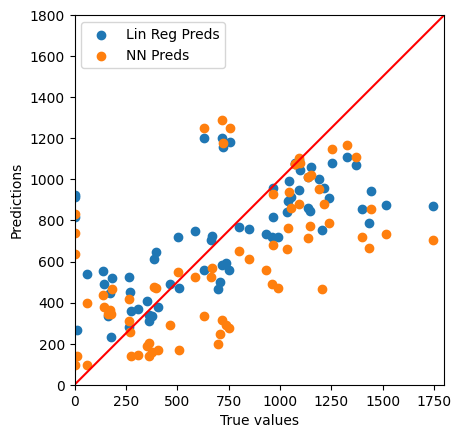

In [117]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")